# Online expectiles, learning rates, and learning stability

In [2]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import matplotlib.style as style; style.use('ggplot')

from expectiles import expectile
from gmm import EXAMPLE

## Example distribution

We'll want an example multi-modal distribution to play around with.

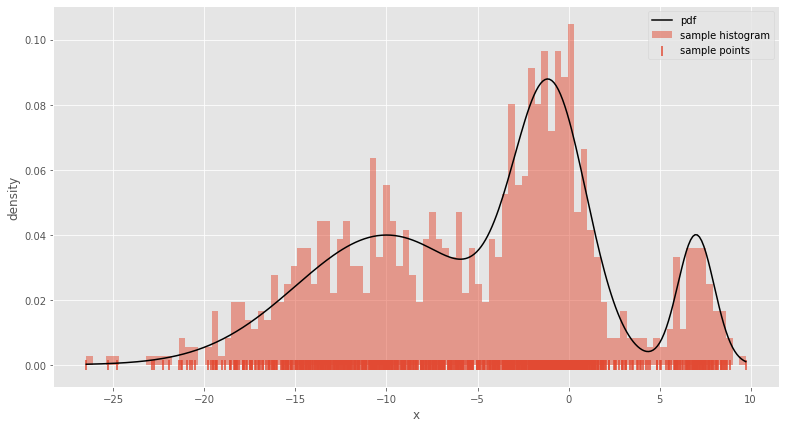

In [3]:
SAMPLE, GMM_X, GMM_Y = EXAMPLE(1000)

## Learning the mean

We can approximate the mean of a sample online by progressively updating an estimate as we see sample points: Let $x_t$, $t=1,\ldots,N$ be the sample. Define $\mu_t$ as the estimate of the sample mean after seeing $x_1$ through $x_t$. Then, the following update rule describes how to compute the $\mu_t$ incrementally (starting from some arbitrary $\mu_0$):

$$
\mu_t = \mu_{t-1} + \alpha \cdot (x_t - \mu_{t-1}).
$$

We can think of this computation as a system 'learning' to 'predict' the sample points, iteratively updating its running prediction in proportion to the observed 'prediction error':

$$
\mu_t
=
\underbrace{\mu_{t-1}}_{\text{previous estimate}}
+
\alpha
\cdot
\underbrace{(x_t - \mu_{t-1})}_{\text{prediction error}}.
$$

Over time, the prediction will track the sample mean, the point where the expected positive and negative variation is minimised. Loosely speaking, when the system is predicting the mean, there tend to be just as much positive error happening as negative error, and so the system will be stable in this position.

In these equations, $\alpha$ represents the 'learning rate'. It determines how strongly the system reacts to errors, thereby controlling the speed and stability of the learning process.

Let's see this idea in action!

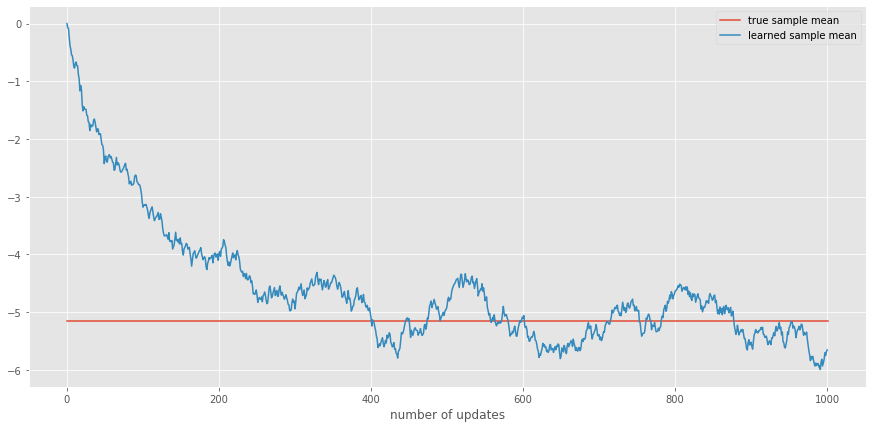

In [6]:
# compute the true sample mean offline
true_mean = np.mean(SAMPLE)

# or compute it online by updating in response to each sample we see
# (over time, the value will balance aroud the true sample mean)
pred_mean = np.zeros(SAMPLE.size+1)
learn_rate = 0.01
for t, x in enumerate(SAMPLE, 1):
    pred_error = x - pred_mean[t-1]
    pred_mean[t] = pred_mean[t-1] + learn_rate * pred_error

plt.figure(figsize=(15, 7))
plt.plot([0, SAMPLE.size+1], [true_mean, true_mean], label="true sample mean")
plt.plot(pred_mean, label="learned sample mean")
plt.xlabel("number of updates")
plt.legend()
plt.show()

### Setting the learning rate

The choice of learning rate is important because determines the balance between speed and stability in the learning process: Too high, and learning will be unstable, with predictions wildly varying in response to errors. Too low, and the system will be 'overstable', learning slowly and inefficiently.

For example, here's the same experiment as above, but with two additional learning rates (one too high and one too low):

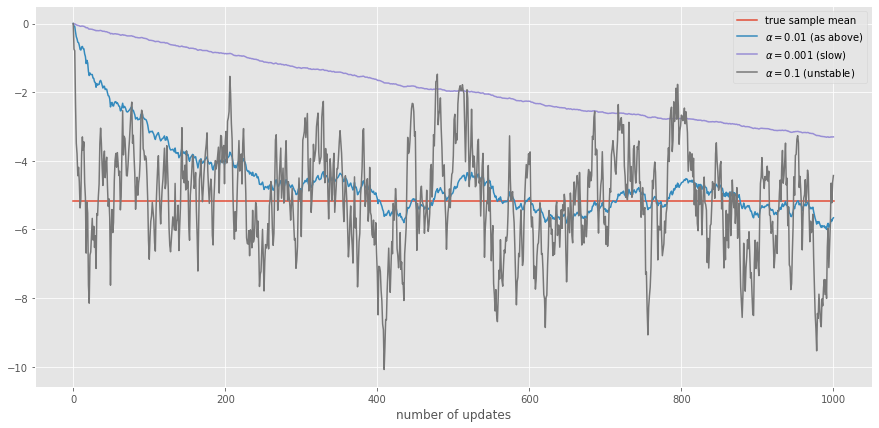

In [7]:
# recompute but with a much higher / lower learning rate:
pred_slow = np.zeros(SAMPLE.size+1)
pred_fast = np.zeros(SAMPLE.size+1)
learn_rate_slow = 0.001
learn_rate_fast = 0.1
for t, x in enumerate(SAMPLE, 1):
    pred_slow[t] = pred_slow[t-1] + learn_rate_slow * (x - pred_slow[t-1])
    pred_fast[t] = pred_fast[t-1] + learn_rate_fast * (x - pred_fast[t-1])

plt.figure(figsize=(15, 7))
plt.plot([0, SAMPLE.size+1], [true_mean, true_mean], label="true sample mean")
plt.plot(pred_mean, label=r"$\alpha=0.01$ (as above)")
plt.plot(pred_slow, label=r"$\alpha=0.001$ (slow)")
plt.plot(pred_fast, label=r"$\alpha=0.1$ (unstable)")
plt.xlabel("number of updates")
plt.legend()
plt.show()

## Learning other expectiles

The process above computes the mean of the distribution of the samples. However, we can do something similar for other expectiles, too! We just have to use an *asymmetric* learning rate: a different learning rate for updates in response to positive and negative prediction errors.

If we use:

* $\alpha_+$ in responding to positive prediction errors (values greater than the current estimate), and 
* $\alpha_-$ in responding to negative prediction errors (values less than the current estimate),

then the learned value should stabilise at the expectile $\epsilon_\tau$ where:

$$
\tau = \frac{\alpha_+}{\alpha_+ + \alpha_-}
$$
or, equivalently,
$$
\frac{\alpha_+}{\alpha_-} = \frac{\tau}{1-\tau}.
\tag{1}$$

This happens because the learning process will need to move away from the mean to find an equilibrium where the number and scale of positive errors compared to negative errors counteracts the asymmetry in the positive and negative learning rates.

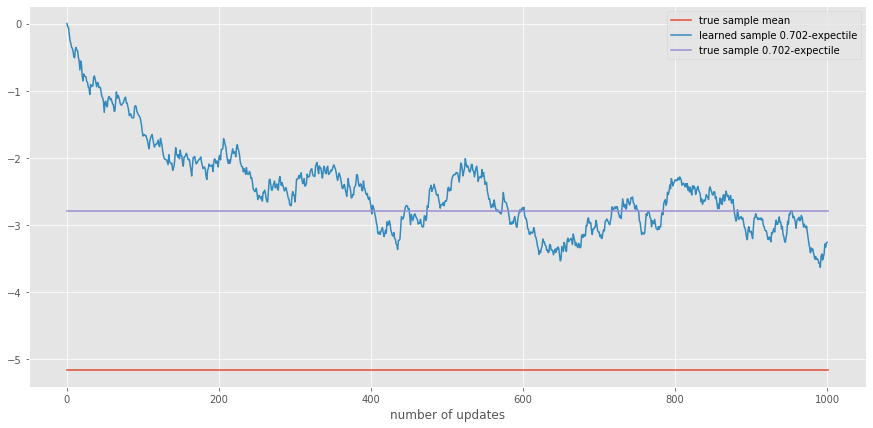

In [8]:
# a different learning rate for positive and negative errors
neg_learn_rate = 0.0065
pos_learn_rate = 0.0153
pred_expt = np.zeros(SAMPLE.size+1)
for i, x in enumerate(SAMPLE, 1):
    pred_error = x - pred_expt[i-1]
    if pred_error  > 0:
        # positive prediction error: sample higher than 'expected'
        pred_expt[i] = pred_expt[i-1] + pos_learn_rate * pred_error
    else:
        # negative prediction error: sample lower than 'expected'
        pred_expt[i] = pred_expt[i-1] + neg_learn_rate * pred_error

# the corresponding tau is given by equation (1)
tau = pos_learn_rate / (pos_learn_rate + neg_learn_rate) # ~= 0.702
true_expt = expectile(SAMPLE, tau)

plt.figure(figsize=(15, 7))
plt.plot([0, SAMPLE.size+1], [true_mean, true_mean], label=f"true sample mean")
plt.plot(pred_expt, label=f"learned sample {tau:.3f}-expectile")
plt.plot([0, SAMPLE.size+1], [true_expt, true_expt], label=f"true sample {tau:.3f}-expectile")
plt.xlabel("number of updates")
plt.legend()
plt.show()

### Setting the learning rates

Rearranging equation (1), if we want to learn a particular $\tau$-expectile, we can, for example, set the negative rate $\alpha_-$ and then set the positive rate $\alpha_+$ in terms of $\alpha_-$:

$$
\alpha_+ = \frac{\tau}{1-\tau}\alpha_-.\tag{2}
$$

We could pick the value for $\alpha_-$ to be some reasonable 'base' learning rate, independent of $\tau$, for example.

Let's try to use this scheme to learn a range of expectiles!

In [12]:
# compute the true expectile values offline
taus = np.linspace(0.01, 0.99, 7)
true_expts = expectile(SAMPLE, taus)

learning...
plotting...


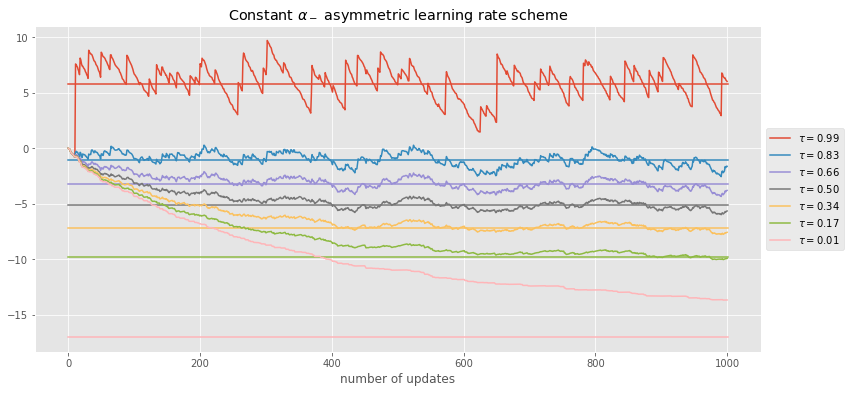

In [14]:
# configure learning rates
base_learn_rate = 0.01
neg_learn_rates = base_learn_rate * np.ones_like(taus)
pos_learn_rates = base_learn_rate * (taus/(1-taus))

print("learning...")
pred_expts = np.zeros((SAMPLE.size+1, taus.size))
for i, x in enumerate(SAMPLE, 1):
    pred_errors = x - pred_expts[i-1]
    
    # use negative update rate, except where error was positive
    learn_rates = neg_learn_rates.copy()
    pos_errors = np.where(pred_errors > 0)
    learn_rates[pos_errors] = pos_learn_rates[pos_errors]
    
    # with these rates, perform the update
    pred_expts[i] = pred_expts[i-1] + learn_rates * pred_errors

print("plotting...")
plt.figure(figsize=(13, 6))
for i, (tau, true_expt) in reversed(list(enumerate(zip(taus, true_expts)))):
    (line,) = plt.plot([0, SAMPLE.size+1], [true_expt, true_expt], label=r"$\tau={:.2f}$".format(tau))
    plt.plot(pred_expts[:, i], color=line.get_color())
plt.xlabel("number of updates")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.title("Constant $\\alpha_-$ asymmetric learning rate scheme")
plt.show()

Ah! What happened?

Just like before, it's important to set the learning rates to not be too high or too low. In this case, it's important that *neither* learning rate gets an extreme value. Though the system still shows learning stability near the middle of the $\tau$ range, this learning rate-setting scheme (starting with a constant $\alpha_-$ and multiplying it by $\frac{\tau}{1-\tau}$ to get $\alpha_+$) does not achieve stability for extreme expectiles:

* When $\tau$ is close to 1, $\frac{\tau}{1-\tau}$ is a very large number. This means the positive learning rate becomes much larger than we would desire for a stable updating process. We see this effect in the above plot.
* When $\tau$ is close to 0, $\frac{\tau}{1-\tau}$ is very small, so the positive rate is much smaller than our constant 'base' rate $\alpha_-$, which itself is too slow to drive learning efficiently towards the true expectile.

#### An improved scheme

We need a different way to set the learning rates. For these extreme $\tau$ values. We want the rates to be more balanced, but we also want them to maintain the multiplicative relationship defined in equations (1) and (2).

One way to achieve this is to **geometrically center the two learning rates around a reasonable 'base' learning rate $\alpha$**, such as in the following scheme:

$$
\alpha_- = \alpha \cdot \sqrt{\frac{1-\tau}{\tau}}
\qquad
\alpha_+ = \alpha \cdot \sqrt{\frac{\tau}{1-\tau}}
\tag{3}
$$

This scheme satisfies (1) and results in a geometric average learning rate of $\alpha$ (note: averaged between the two rates, not over the course of learning).

**I hypothesise that the rate-setting scheme outlined by equations (3) is a sensible scheme for achieving stable learning across the full range of possible $\tau$ values.**

Let's try learning a full range of expectiles from our sample, using this scheme!

learning...
plotting...


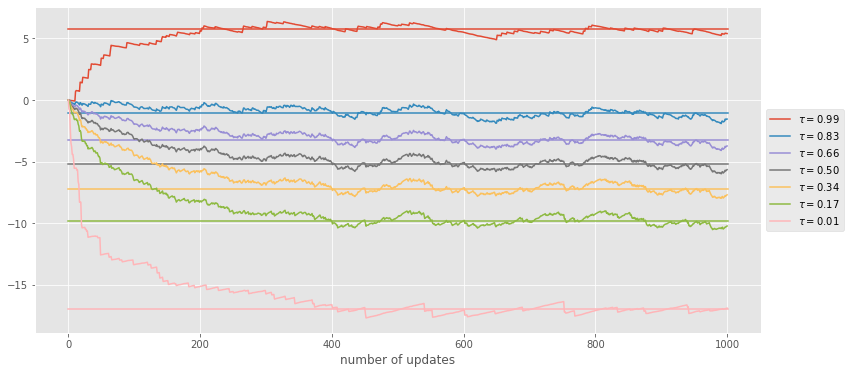

In [17]:
# configure learning rates
learn_rate_factors = np.sqrt(taus/(1-taus))
base_learn_rate = 0.01
neg_learn_rates = base_learn_rate / learn_rate_factors # <-- UPDATED
pos_learn_rates = base_learn_rate * learn_rate_factors # <-- UPDATED

print("learning...")
pred_expts = np.zeros((SAMPLE.size+1, taus.size))
for i, x in enumerate(SAMPLE, 1):
    pred_errors = x - pred_expts[i-1]
    
    # use negative update rate, except where error was positive
    learn_rates = neg_learn_rates.copy()
    pos_errors = np.where(pred_errors > 0)
    learn_rates[pos_errors] = pos_learn_rates[pos_errors]
    
    # with these rates, perform the update
    pred_expts[i] = pred_expts[i-1] + learn_rates * pred_errors

print("plotting...")
plt.figure(figsize=(13, 6))
for i, (tau, true_expt) in reversed(list(enumerate(zip(taus, true_expts)))):
    (line,) = plt.plot([0, SAMPLE.size+1], [true_expt, true_expt], label=r"$\tau={:.2f}$".format(tau))
    plt.plot(pred_expts[:, i], color=line.get_color())
plt.xlabel("number of updates")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()

The effect of scheme (3) shown in the above plot is promising---the learning 'speed' and 'stability' appears uniform accross the range of values.

This difference can be seen also by plotting $\alpha_+$ and $\alpha_-$ as a function of $\tau$ in each case:

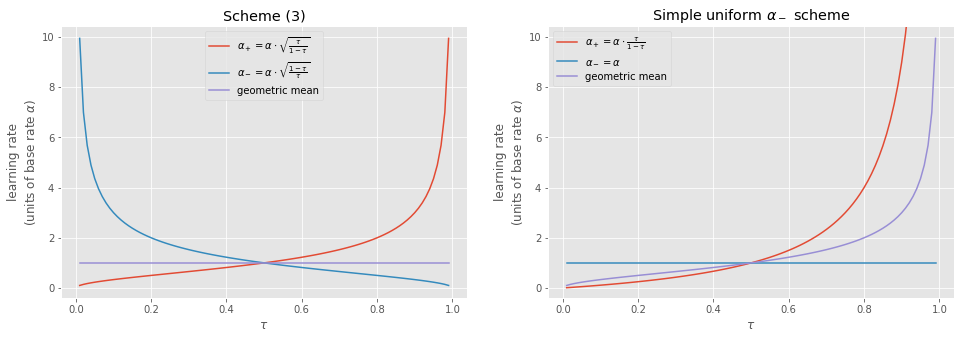

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
x = np.linspace(0.01, 0.99, 99)

y3 = x / (1-x)
y1 = np.sqrt(y3)
y2 = 1 / y1
y4 = np.ones_like(x)
m1 = np.sqrt(y1*y2)
m2 = np.sqrt(y3*y4)

ax1.plot(x, y1, label=r"$\alpha_+ = \alpha \cdot \sqrt{\frac{\tau}{1-\tau}}$")
ax1.plot(x, y2, label=r"$\alpha_- = \alpha \cdot \sqrt{\frac{1-\tau}{\tau}}$")
ax1.plot(x, m1, label="geometric mean")
ax2.plot(x, y3, label=r"$\alpha_+ = \alpha \cdot \frac{\tau}{1-\tau}$")
ax2.plot(x, y4, label=r"$\alpha_- = \alpha$")
ax2.plot(x, m2, label="geometric mean")

ax1.set_title("Scheme (3)")
ax1.set_xlabel(r"$\tau$")
ax1.set_ylabel("learning rate\n(units of base rate $\\alpha$)")
ax1.legend()
ax2.set_ylim(ax1.get_ylim())
ax2.set_title(r"Simple uniform $\alpha_-$ scheme")
ax2.set_xlabel(r"$\tau$")
ax2.set_ylabel("learning rate\n(units of base rate $\\alpha$)")
ax2.legend()

plt.show()

From this plot, it's clear how the updated rate-setting scheme ('scheme (3)', left) improves stability accross the full range of $\tau$ values, compared to the naive scheme (right) where $\alpha_-$ may be too low for low $\tau$ and $\alpha_+$ too high for high $\tau$.

## Neural data

The deepmind paper [[1]] analysed a survey of 40 dopaminergic neurons from a few mice performing a learning task, and estimated the following asymmetric learning rates from the recorded response data.

[1]:   https://doi.org/10.1038/s41586-019-1924-6
[[1]]: *Dabney, W., Kurth-Nelson, Z., Uchida, N. et al. A distributional code for value in dopamine-based reinforcement learning. Nature 577, 671–675 (2020).*

In [18]:
# # code from deepmind notebook:
# # #
# fig5 = scipy.io.loadmat("Figure5.mat")
# zero_crossings = fig5['zeroCrossings'][:, 0]
# neg_scale, pos_scale = np.zeros(40), np.zeros(40)
# for cell in range(zero_crossings.shape[0]):
#     neg_scale[cell] = fig5['scaleFactNeg'][cell, 0]
#     pos_scale[cell] = fig5['scaleFactPos'][cell, 0]
# # #
# hard-coding data:
empirical_aneg = np.array(
    [ 1.09973087, 1.09434475, 0.81754647, 1.75496968, 1.67606203
    , 1.31782321, 4.2774962 , 2.07487821, 1.20795529, 1.79866939
    , 1.5543464 , 1.53714398, 1.75414581, 0.99157462, 1.25610374
    , 1.64890165, 1.11847172, 1.33288318, 1.06756076, 0.13837144
    , 3.18862819, 0.40993265, 1.57898859, 1.25206699, 0.7408865 
    , 1.37378935, 0.64970639, 0.5290385 , 1.15801591, 0.88804109
    , 0.39178265, 0.78761288, 0.9504729 , 0.78957621, 1.8922945 
    , 1.27743886, 0.89029917, 1.35846128, 0.24108255, 0.94215354
    ])
empirical_apos = np.array(
    [ 1.24414574, 1.69343895, 1.19657156, 1.48369474, 1.9833994 
    , 1.58354132, 0.35294234, 1.33308177, 1.05604004, 1.37478407
    , 0.78240602, 0.81737661, 0.59848422, 0.82444628, 1.01318986
    , 0.68250221, 1.0999396 , 0.98199883, 0.40079706,     np.nan # no pos. responses
    , 0.4510079 , 0.79450089, 1.92060389, 1.01949126, 2.06489026
    , 0.79670455, 0.56191573, 1.10647801, 0.69592584, 1.85254849
    , 1.05660636, 1.94111345, 2.16614124, 0.47228333, 1.30471873
    , 1.37844464, 1.20718559, 0.26307763, 1.13978478, 1.92823193
    ])

These measurements report the slope of the firing response for each neuron, in the region below (`empirical_aneg`) and above (`empirical_apos`) the estimated reversal point. That is, they are the slopes of linear regression lines between the following quantities:

* **Dependent variable**: firing rate of the neurons in hertz (spikes per second) above the base firing rate of each neuron.
* **Independent variable**: estimated magnitude (in 'utility space') of the reward on the corresponding trial.

The utility space transformation was performed as follows:

>  Utility was quantified as the mean (baseline-subtracted) dopaminergic firing rate in response to the relevant reward volume.

According to the code, the mean was taken over all cells for each reward volume. That is, take the average firing rate of all neurons in response

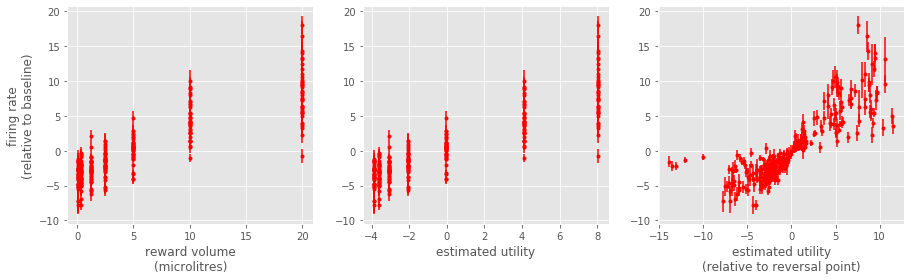

In [151]:
fig5 = scipy.io.loadmat("data/Figure5.mat")
zero_crossings = fig5['zeroCrossings'][:, 0]
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

all_data = []
for cell in range(zero_crossings.size):
    es = scipy.stats.sem(fig5['perCell'][cell], axis=1, nan_policy='omit').data
    ys = np.nanmean(fig5['perCell'][cell], -1)
    xs1 = np.array([0.1, 0.3, 1.2, 2.5, 5, 10, 20])
    xs2 = fig5['utilityAxisPerCell'].mean(axis=0)
    xs3 = fig5['utilityAxisPerCell'][cell]
    for xs, ax in zip([xs1, xs2, xs3], [ax1, ax2, ax3]):
        ax.errorbar(x=xs, y=ys, yerr=es, marker=".", linestyle="", color="red")
    all_data.extend([(x, y) for x, y in zip(xs2, ys)])
ax1.set_ylabel("firing rate\n(relative to baseline)")
ax1.set_xlabel("reward volume\n(microlitres)")
ax2.set_xlabel("estimated utility")
ax3.set_xlabel("estimated utility\n(relative to reversal point)")
all_data = np.array(all_data)
plt.show()

In [142]:
# reproduce utility mapping, to check I understand it
# relevant matlab code:
# mpc = nanmean(perCell,3); 
# utilityAxis = mean(mpc,1); % the empirical utility function
# utilityAxisPerCell_all = utilityAxis - zeroCrossings_all
reproducedUtilityAxis = np.mean(np.nanmean(fig5["perCell"], 2), 0)
reproducedUtilityAxisPerCell = reproducedUtilityAxis[None] - zero_crossings[:, None]
# compare to exported values
print(np.isclose(reproducedUtilityAxisPerCell, fig5['utilityAxisPerCell']))
# out:
# [[ True  True  True  True  True  True  True]
#  [ True  True  True  True  True  True  True]
#  ...
#  [False False False False False False False] # <-- no positive responses
#  ...
#  [ True  True  True  True  True  True  True]
#  [ True  True  True  True  True  True  True]]
# yessss!!

slope of all utility-transformed data


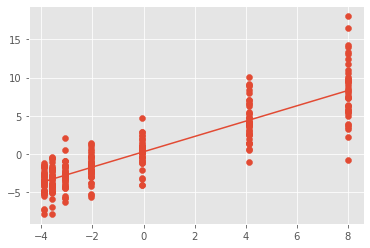

LinregressResult(slope=1.000000000000001, intercept=0.3061676176222462, rvalue=0.8798732521810143, pvalue=8.09930551389075e-92, stderr=0.03239228841198519)

average slopes fitted to data from each neuron
1.0


In [153]:
print("slope of all utility-transformed data")
line = slope, intercept, *_ = scipy.stats.linregress(all_data)
plt.scatter(*all_data.T)
plt.plot(all_data.T[0], all_data.T[0]*slope + intercept)
plt.show()
print(line)

print()
print("average slopes fitted to data from each neuron")
lines = []
for cell in range(40):
    xs = fig5['utilityAxisPerCell'][cell]
    ys = np.nanmean(fig5['perCell'][cell], axis=-1)
    line = scipy.stats.linregress(xs, ys)
    lines.append(line)
print(np.mean([line.slope for line in lines]))

Let's see how these learning rates from *real mice neurons* measure up to the schemes hypothesised above!

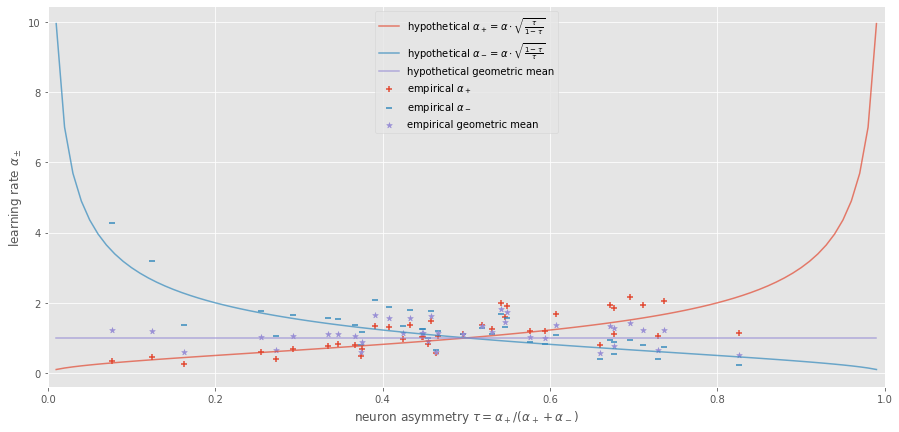

In [15]:
# If the neurons follow scheme (3) as outlined above,
# then we should see the following rates (in units
# of some base rate):
theory_taus = np.linspace(0.01, 0.99, 99)
theory_apos = np.sqrt(theory_taus / (1-theory_taus))
theory_aneg = 1 / theory_apos
theory_mean = np.ones_like(theory_taus) # = np.sqrt(theory_apos * theory_aneg)

# The experiment reveals the following:
empirical_taus = empirical_apos / (empirical_apos + empirical_aneg)
empirical_mean = np.sqrt(empirical_apos * empirical_aneg)

# let's see what happens!
plt.figure(figsize=(15, 7))
plt.plot(theory_taus, theory_apos, alpha=0.7, label=r"hypothetical $\alpha_+ = \alpha \cdot \sqrt{\frac{\tau}{1-\tau}}$")
plt.plot(theory_taus, theory_aneg, alpha=0.7, label=r"hypothetical $\alpha_- = \alpha \cdot \sqrt{\frac{1-\tau}{\tau}}$")
plt.plot(theory_taus, theory_mean, alpha=0.7, label="hypothetical geometric mean")
plt.scatter(empirical_taus, empirical_apos, marker="+", label=r"empirical $\alpha_+$")
plt.scatter(empirical_taus, empirical_aneg, marker="_", label=r"empirical $\alpha_-$")
plt.scatter(empirical_taus, empirical_mean, marker="*", label="empirical geometric mean")
plt.xlim([0, 1])
plt.xlabel(r"neuron asymmetry $\tau = \alpha_+ / (\alpha_+ + \alpha_-)$")
plt.ylabel(r"learning rate $\alpha_\pm$")
plt.legend()
# plt.savefig("learning_rate_stability.png")
plt.show()

That seems like one striking fit!